# Numba for Robotics Tutorial

## Why use Numba for Robotics?

Python has a lot of benefits for robotics - it allows fast prototyping of algorithms, and supports many useful libraries for numerical computations, machine learning, and computer vision. Furthermore, it also supports the Robotic Operating System ([ROS](http://wiki.ros.org/Documentation)) which provides basic frameworks and tools to develop code for robots. However, Python is also slower than compiled languages. Robotics algorithms often include many time-consuming and/or repetitive calculations. For example, a robot may need to process thousands or tens of thousands of data points from a laser sensor every second to find its location in a room. 

Because robotics has many repetitive calculations, and running code in real-time is important, we need some way to speed up Python code. [Numba](http://numba.pydata.org/) is a just-in-time compiler which greatly speeds up Python code, letting us run calculations like these in real time while still retaining all the other advantages of Python. Numba is especially great for speeding up loops, which can otherwise be quite slow. It also supports the numpy library for calculations with arrays. For a more comprehensive list of features supported by Numba, refer [here](http://numba.pydata.org/numba-doc/0.17.0/reference/pysupported.html). 

Numba accelerates Python code by generating a specialized implementation for the specific data types used in the code. Therefore to use Numba, your code must be structured to use only numba-supported data types. Numba focuses on numerical data types - it does not support some types such as dictionaries and has limited string processing support. This tutorial will teach you how to properly use Numba. We'll first go over a simple code example showing the basics, then see a robotics-specific example, using Numba to speed up a particle filter.

## Simple example: Use Numba to speed up computation

We'll first use Numba to speed up some simple computations in Python. This section will teach you the common best practices of using Numba and demonstrate its benefits. First, make sure Numba is installed on your computer. In order to install Numba, check out these [instructions](http://numba.pydata.org/numba-doc/latest/user/installing.html). The following code defines the factorial function, which we'll use for a runtime comparison with Numba.

In [1]:
import numpy as np

def factorial(n):
    result = 1
    if (n < 0):
        return np.nan
    elif (n == 0):
        return 0
    else:
        for i in range(1, n+1):
            result = result*i
    return result

Run the following cell which uses the `%timeit` function to calculate the runtime of the specified function.

In [2]:
%timeit factorial(7)

730 ns ± 17.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Now that you have checked the speed of the current function without using Numba, it is time to incorporate Numba into the code. 

First, import Numba into your code. Then, add the `@jit` function decorator, which Numba uses to indicate which function it should compile. You can see how the factorial function from above has Numba incorporated using the `@jit` function decorator below. Run the `%timeit` cell for the `factorial_jit` function below to check the speed, and you should notice that the runtime is much shorter.

In [3]:
import numpy as np
from numba import jit #Step 1: import Numba

@jit #Step 2: Add the @jit function decorator
def factorial_jit(n):
    result = 1
    if (n < 0):
        return np.nan
    elif (n == 0):
        return 0
    else:
        for i in range(1, n+1):
            result = result*i
    return result

In [5]:
%timeit factorial_jit(7)

157 ns ± 3.66 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


`@jit` compiles the decorated function on-the-fly to produce efficient machine code. This allows our functions to run at machine code speed, rather than the slower Python runtime. The just-in-time compilation can make the function slower at the first call. However, after the first use, Numba caches the function's machine code which makes it run faster than the first time since it does not need to compile again. If you did not see much of a decrease in runtime, it's likely because of this extra compilation time - try running `%timeit` again, and see if the runtime improves.

### Numba Modes (Object mode vs nopython mode)

In this section, we will learn about the two different compilation modes of Numba. These two modes are the object mode and the nopython mode. Object mode does not do any type-specialization making sure that the types used in the function are only the ones that Numba supports. In object mode, Numba compiles the parts of code that it can into machine code, and leaves the rest of the code for the Python interpreter. Even if Numba is completely unable to compile, `@jit` still runs the function and does not inform the user that Numba failed to enhance the code. For example, let's run the code sample below, which contains dictionaries. Numba is unable to compile code that uses dictionaries, so we might expect this to result in an error.

In [6]:
# code with dictionary example
from numba import jit

alpha = {11: "a", 21: "b", 34: "c", 40: "d"}

@jit
def first_even_plc(d):
    for key in d:
        if (key % 2 == 0):
            return d[key]
        
    return d[1]

first_even_plc(alpha)

<ipython-input-6-63d887efc587>:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "first_even_plc" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-6-63d887efc587> (8)

File "<ipython-input-6-63d887efc587>", line 8:
def first_even_plc(d):
    for key in d:
    ^

  @jit
/Users/ikramonjur/anaconda/envs/info3350/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "first_even_plc" was compiled in object mode without forceobj=True.

File "<ipython-input-6-63d887efc587>", line 7:
@jit
def first_even_plc(d):
^

  state.func_ir.loc))
/Users/ikramonjur/anaconda/envs/info3350/lib/python3.6/site-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/

'c'

However, this code executes without crashing and simply generates a warning. This is not the ideal situation, since we might end up running code that we think is optimized, but actually isn't. We want to be notified when Numba fails to work. Therefore, Numba includes a "nopython mode" which enforces type-specialization, so that if Numba is unable to compile a piece of code, it will generate an error. The `@jit` function decorator first tries using the nopython mode, then switches to object mode if it fails in nopython mode. To enforce nopython mode, add a `nopython=True` parameter so, `@jit(nopython=True)`, or simply use `@njit`. Both of these are equivalent. Run the cell below which has the `@njit` function decorator instead of `@jit`, and you should see an error since dictionaries are not supported by Numba.

To make sure Numba is accelerating your code, **it is best practice to always use nopython mode**, which enforces Numba type specialization.

In [7]:
from numba import jit, njit

alpha = {11: "a", 21: "b", 34: "c", 40: "d"}

@njit
def first_even_plc(d):
    for key in d:
        if (key % 2 == 0):
            return d[key]
        
    return d[1]

first_even_plc(alpha)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
[1] During: typing of argument at <ipython-input-7-13424381bd72> (7)

File "<ipython-input-7-13424381bd72>", line 7:
def first_even_plc(d):
    for key in d:
    ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'dict'>


One other requirement of nopython mode is that Numba is not able to allocate memory for new arrays inside an `@njit` function. In this next example, we'll see how to structure code to deal with this limitation.

In [21]:
import math
import numpy as np
from numba import njit

@njit
def quad_eq(a,b,c):
    roots = np.zeros(2)
    d = b**2 - 4*a*c
    if (d < 0):
        return np.nan
    x1 = (-b + math.sqrt(d))/(2*a)
    x2 = (-b - math.sqrt(d))/(2*a)
    roots[0] = x1
    roots[1] = x2
    
    return roots

quad_eq(1,8,1)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Can't unify return type from the following types: array(float64, 1d, C), float64
Return of: IR name '$46.30', type 'array(float64, 1d, C)', location: 
File "<ipython-input-21-4d8fa33c87fa>", line 16:
def quad_eq(a,b,c):
    <source elided>
    
    return roots
    ^
Return of: IR name '$40.3', type 'float64', location: 
File "<ipython-input-21-4d8fa33c87fa>", line 10:
def quad_eq(a,b,c):
    <source elided>
    if (d < 0):
        return np.nan
        ^

The function above needs to return two values, which it does by returning a numpy array. Check the current runtime of the function by running the following cell.

In [9]:
%timeit quad_eq(1,8,1)

1.8 µs ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


However, the problem with the previous function is that it returns a new numpy array, which is not allowed by Numba. Try adding the `@njit` function decorator to the `quad_eq` function to see what error you get. In Numba, functions are not allowed to create new arrays, because it is difficult for Numba to allocate new memory while also converting the code to machine code. To learn more about this, refer to this [link](http://numba.pydata.org/numba-doc/0.15.1/arrays.html). In order to fix this issue, we can simply pass an already allocated numpy array into the function and modify that in place. The following function does exactly that.  

#### Exercise 1:
Now let's try incorporating Numba into the following function by the steps mentioned previously. Make sure to use the `@njit` function decorator instead of the `@jit`.

In [11]:
import math
import numpy as np

#TODO: import numba
from numba import jit, njit 

roots = np.zeros(2)
#TODO: add function decorator
@njit
def quad_eq_jitted(a,b,c,roots):
    d = b**2 - 4*a*c
    if (d < 0):
        return np.nan
    x1 = (-b + math.sqrt(d))/(2*a)
    x2 = (-b - math.sqrt(d))/(2*a)
    roots[0] = x1
    roots[1] = x2

quad_eq_jitted(1,8,1,roots)
roots

array([-0.12701665, -7.87298335])

In [12]:
%timeit quad_eq_jitted(1,8,1,roots)

404 ns ± 19.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Robotics example: Using Numba to speed up a particle filter

Next, let's look at a robotics-specific example of how Numba speeds up repetitive calculations. This is an example of a particle filter, an algorithm used for localization of a robot. If you are unfamiliar with the particle filter, first watch [this video](https://www.youtube.com/watch?v=aUkBa1zMKv4).

In a particle filter, there are four main steps. Let $x$ be the state of a particle, z be the measurements acquired by the robot's sensors, w be the weight of a particle, i be the particle number, and t be the iteration number.
 
- Initialization: Sample particles from uniform distribution 

$ x_0^i \sim p(x_0)$

- Prediction: Predict the new states of the particles using the robot dynamics

$ \bar{x_0^i} \sim p(x_t^i | x_{t-1}^i, u_t)$

- Measurement Update: Update the weights of the particles using new measurements from robot

$ w_t^i = p(z_t |\bar{x_t^i} )$ 

- Resampling: Pick the particles with the highest weights for the next iteration

The prediction, measurement update, and resampling steps are repeated for each particle, causing the algorithm to be slow when it uses many particles. In practice, particle filters may use hundreds or thousands of particles.

For a more mathematical explanation, refer to [this paper](http://robots.stanford.edu/papers/thrun.pf-in-robotics-uai02.pdf). Since a particle filter repeats the same computations multiple times, we can expect a significant speedup by compiling these functions with Numba.


For this example problem, we have a robot moving around a 2D world. The robot has a sensor on it that measures the distance from the robot to 3 non-moving landmarks. This setup is shown in the figure below. The red circle is the robot and the pink squares are the landmarks.

![alt text](map2.jpeg "Map")

The `diffRobot_localizeRobot.txt` dataset contains these sensor measurements and the $\omega$ (angular velocity) of the robot at each time-stamp, with a total of 500 data points collected over 50 seconds. The velocity of the robot is set to a constant. Furthermore, the dataset also contains the ground truth location of the robot at each timestamp, which is used to show the accuracy of the particle filter. 

Let's look at the `dynamics_function` of the particle filter. This function, which is used in the prediction step, updates the positions of the particles (`robot_pose`) given the controls used by the actual robot. At each time step, this function needs to be called once per each particle, so it's important to make it run quickly. Before completing Exercise 2, run the `%timeit` cell to understand the performance enhancement before and after Numba.

#### Exercise 2:

Below you will find the dynamics function without Numba incorporated into it. Follow the steps from previous exercises to speed up the function using Numba.

In [17]:
import numpy as np
import math
#TODO: Step 1: import Numba 
from numba import njit
'''
Arguments:
robot_pose: position of a particle
commands: the commands given to the robot (v,w)
dt: the change in time

Returns:
Output of the function is the new particle position after the 
new commands are applied to the given position
''' 
#TODO: step 2: add function decorator njit
@njit
def dynamics_function(robot_pose, commands, dt):
    theta = robot_pose[2]
    dx = commands[0] * math.cos(theta) * dt 
    dy = commands[0] * math.sin(theta) * dt 
    dtheta = commands[1] * dt 
    new_pose = np.array([robot_pose[0] + dx, robot_pose[1] + dy, robot_pose[2] + dtheta])
        
    return new_pose

Again, run the cell below after completing Exercise 2 to get the new run-time of the dynamics function.

In [18]:
%timeit dynamics_function(np.array([1,1,0.5]), np.array([0.5, 0.1]), 0)

2.91 µs ± 40 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Let's now also look at the unmodified `measurement_function` in the cell below. The following code is the measurement function of the particle filter, which calculates the expected measurements to each of the landmarks on the map for each particle. By comparing these expected measurements to the actual observations, we can figure out which particles are more accurate guesses of where the robot is. The `measurement_function` currently uses datatypes not supported in Numba. As seen in the previous section, using `@njit` with the current function will cause errors. 

For the next exercise, try looking for data types that don’t work with Numba in the code below. Using this [link](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) as a reference, change those data types in the code. Modify the code such that it works with Numba, and `@njit` does not cause any errors.

#### Exercise 3:

Incorporate Numba into the measurement function given below. First, make sure to import Numba and add the function decorator as shown before. The function uses a dictionary, which is not supported in Numba. One recommendation is to use a numpy array instead of the dictionary. Lastly, we are not allowed to allocate new memory inside the function, so to fix that issue, refer to the code from Exercise 1.

In [19]:
import numpy as np
#TODO: Step 1: import Numba 
'''
Arguments:
robot_pose: position of a particle
tags_dict: the landmark locations on the map given as a dictionary

Returns:
Output of the function is the measurement we expect the robot to see 
at the given robot_pose.
The measurement is formatted as a dict of {landmark_number: landmark_measurement}
''' 
#TODO: step 2: add function decorator njit
def measurement_function(robot_pose, tags_dict):
    #TODO: step 3: change datatypes to ones that support Numba
    #TODO: step 4: make sure you are not allocating new memory in the function
    measurement = {}
    for tag_number in range(0,3):
        tag_pose = tags_dict[tag_number]
        measurement[tag_number] = tag_pose - robot_pose[:2]
    return measurement

Run the cell below to check the runtime of the `measurement_function` before and after Numba.

In [20]:
tags_dict = {}
tags_dict[0] = [0.75, -1.25]
tags_dict[1] = [-1.1, 0.8]
tags_dict[2] = [1.5, 2.1]

# The numpy array with the landmark locations on the map is provided when testing with jit
tags_arr = np.zeros((3,2))
tags_arr[0] = [0.75, -1.25]
tags_arr[1] = [-1.1, 0.8]
tags_arr[2] = [1.5, 2.1]

%timeit measurement_function(np.array([1,1,0.5]), tags_dict)

8.1 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
## SOLUTION
@njit
def measurement_function_jit(robot_pose, tags_arr, measurement):
    for tag_number in range(0,3):
        tag_pose = tags_arr[tag_number]
        measurement[tag_number] = tag_pose - robot_pose[:2]

In [23]:
## SOLUTION
tags_arr = np.zeros((3,2))
tags_arr[0] = [0.75, -1.25]
tags_arr[1] = [-1.1, 0.8]
tags_arr[2] = [1.5, 2.1]

measurement = np.zeros((3, 2))

%timeit measurement_function_jit(np.array([1,1,0.5]), tags_arr, measurement)

2.36 µs ± 16.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Lastly, we will look at the whole particle filter code below with all the necessary modifications needed already in place. Here we simply read a text file in order to get all the data necessary to run our particle filter.

In [6]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import math
from numba import njit


#actual landmark values as numpy array
tags_arr = np.zeros((3,2))
tags_arr[0] = [0.75, -1.25]
tags_arr[1] = [-1.1, 0.8]
tags_arr[2] = [1.5, 2.1]

#actual landmark values as dictionary
tags_dict = {}
tags_dict[0] = [0.75, -1.25]
tags_dict[1] = [-1.1, 0.8]
tags_dict[2] = [1.5, 2.1]

incr = 0
speed = 0.5 #stays constant
data = open('diffRobot_localizeRobot.txt', 'r')
lines = data.readlines()

dataSet = [] #arrays of time, control, landamrks 1 to 4
robot = []

for line in lines:
    time, robotState, control, landmark1, landmark2, landmark3, landmark4 = line.split(",")

    robotState = robotState[2:-1]
    rx, ry, theta = robotState.split()
    robotState = []
    rx = float(rx)
    ry = float(ry)
    theta = float(theta)
    robotState.append(rx)
    robotState.append(ry)
    robotState.append(theta)

    robot.append(robotState)

    control = control[2:-1]
    control = float(control)
    time = float(time)

    landmark2 = landmark2[2:-1]
    l1, l2 = landmark2.split()
    landmark2 = []
    l1 = float(l1)
    l2 = float(l2)
    landmark2.append(l1)
    landmark2.append(l2)

    landmark3 = landmark3[2:-1]
    l1, l2 = landmark3.split()
    landmark3 = []
    l1 = float(l1)
    l2 = float(l2)
    landmark3.append(l1)
    landmark3.append(l2)

    landmark4 = landmark4[2:-2]
    l1, l2 = landmark4.split()
    landmark4 = []
    l1 = float(l1)
    l2 = float(l2)
    landmark4.append(l1)
    landmark4.append(l2)

    new = []
    new.append(time)
    new.append(control)
    new.append(landmark2)
    new.append(landmark3)
    new.append(landmark4)
    dataSet.append(new)

Below are the functions that we are using in order to build our filter. We will create two particle filters, one with Numba and one without, for direct comparison. Most of these functions in the particle filter use the `@njit` function decorator, but some do not. Can you figure out why some of them are not supported by Numba?

The cell below shows the `create_uniform_particles` function which creates random particles with a uniform distribution in the beginning. There are only slight differences between these two functions. The one with Numba takes an extra parameter, since Numba functions are not allowed to allocate new memory to create arrays. So, this is again another example of changing something in place when using Numba.

In [7]:
def create_uniform_particles(spanX1, spanX2, spanY1, spanY2, spanTheta1, spanTheta2, numParticles=200):
    particleSet = np.zeros([numParticles, 3])
    xSamples = np.random.uniform(spanX1, spanX2, numParticles)
    ySamples = np.random.uniform(spanY1, spanY2, numParticles)
    thetaSamples = np.random.uniform(spanTheta1, spanTheta2, numParticles)
    for i in range(0, numParticles):
        particleSet[i, :] = [xSamples[i], ySamples[i], thetaSamples[i]]
    return particleSet

@njit
def create_uniform_particles_jit(spanX1, spanX2, spanY1, spanY2, spanTheta1, spanTheta2, particleSet, numParticles=200):
    xSamples = np.random.uniform(spanX1, spanX2, numParticles)
    ySamples = np.random.uniform(spanY1, spanY2, numParticles)
    thetaSamples = np.random.uniform(spanTheta1, spanTheta2, numParticles)
    for i in range(0, numParticles):
        particleSet[i, :] = [xSamples[i], ySamples[i], thetaSamples[i]]
        

Now, let's look at the `measurement_function` again. There are two of them - one that uses Numba and one that doesn't. As seen in the exercise above, the one without Numba uses dictionaries and creates new objects, which are not allowed in Numba nopython mode. Copy your new `measurement_function` from exercise 3 inside the `measurement_function_jit` below.

In [8]:
def measurement_function(robot_pose, tags_dict):
    measurement = {}
    for tag_number in range(0,3):
        tag_pose = tags_dict[tag_number]
        measurement[tag_number] = tag_pose - robot_pose[:2]
    return measurement

## SOLUTION
@njit
def measurement_function_jit(robot_pose, tags_arr, measurement):
    for tag_number in range(0,3):
        tag_pose = tags_arr[tag_number]
        measurement[tag_number] = tag_pose - robot_pose[:2]

Lastly, let's compare the two `update` functions. The update function, without Numba incorporated, uses the multivariate pdf function from the scipy library. However, Numba does not support this function so the `calc_pdf` function which does the exact same computation was created.

In [9]:
def update(particles, particleWeights, tags_dict, robo_tags):
    sigma = np.array([[0.1, 0], [0, 0.1]])

    for j in range(0, len(particles)):
        measurement = measurement_function(particles[j], tags_dict)
        
        particleWeight = 1
        for id in range(0,3):
            particleWeight *= mvn.pdf(np.array(measurement.get(id)), mean=robo_tags[id], cov=sigma)
        particleWeights[j] = particleWeight

    # re-scale the particle weights so that the sum of weights = 1
    particleWeights /= sum(particleWeights)

    return particleWeights

@njit
def calc_pdf(x, mu, sigma):
    k = len(x)
    sig_det = np.linalg.det(sigma)
    sig_inv = np.linalg.inv(sigma)
    G = ( 1/ ( np.sqrt(((2*np.pi)**k)*sig_det) ) )
    G *= np.exp( - (0.5 * (x - mu).T.dot(sig_inv).dot( (x - mu) ) ) )
    return G

@njit
def update_jit(particles, particleWeights, tags_arr, robo_tags, measurement):
    sigma = np.array([[0.1, 0], [0, 0.1]])
    
    for j in range(0, len(particles)):
        robot_pose = particles[j]
        measurement_function_jit(particles[j], tags_arr, measurement)
    
        particleWeight = 1
        for id in range(0,3):
            particleWeight *= calc_pdf(measurement[id], robo_tags[id], sigma)
    
        particleWeights[j] = particleWeight

    # re-scale the particle weights so that the sum of weights = 1
    particleWeights /= np.sum(particleWeights)

    return particleWeights



Below are some of the other functions that are used for the particle filter. 

In [10]:
@njit
def dynamics_function_jit(robot_pose, commands, dt):
    theta = robot_pose[2]
    dx = speed * math.cos(theta) * dt 
    dy = speed * math.sin(theta) * dt 
    dtheta = commands * dt 
    new_pose = np.array([robot_pose[0] + dx, robot_pose[1] + dy, robot_pose[2] + dtheta])
        
    return new_pose

def dynamics_function(robot_pose, commands, dt):
    theta = robot_pose[2]
    dx = speed * math.cos(theta) * dt 
    dy = speed * math.sin(theta) * dt 
    dtheta = commands * dt 
    new_pose = np.array([robot_pose[0] + dx, robot_pose[1] + dy, robot_pose[2] + dtheta])
        
    return new_pose

def predict(particles, commands, dt):
    for i in range(0, len(particles)):
      particles[i] = dynamics_function(particles[i], commands, dt)
      particles[i] = np.random.normal(loc = particles[i], scale = sigma)
    return particles

def resample(particleWeights, particleSet, numParticles, selectedIndices):
    newParticles = np.zeros((numParticles, 3))
    for j in range(0, len(selectedIndices)):
        # new particle set is being created
        newParticles[j] = particleSet[selectedIndices[j]]
    return newParticles

This is our main particle filter. The `numParticles` parameter is the number of particles used by the filter. The larger the number of particles, the more time each iteration takes to run.

There are two particle filters below - one with Numba (`p_filter_jit`) and one without Numba (`p_filter`).

In [11]:
#sensor noise
sigma = np.array([0.05, 0.05, 0.1])
sigma2 = np.array([[0.1, 0], [0, 0.1]])

#particle filter - without jit
def p_filter(numParticles):
    allPsets = []
    particleSet = create_uniform_particles(-4, 4, -4, 4, 0, 2*math.pi, numParticles)
    #change in time
    dt = 0
    for i in range(0, len(dataSet)):
        allPsets.append(particleSet)
        control = dataSet[i][1] # control value
        if (i < len(dataSet) - 1):
            dt = math.fabs(dataSet[i + 1][0] - dataSet[i][0]) #diff betwn 2 consecutive time stamps
        else:
            dt = dt

        #update location using dynamics
        particleSet = predict(particleSet, control, dt)

        robo_tags = np.zeros((3, 2))
        for l in range(2, 5):
            robo_tags[l-2] = [dataSet[i][l][0], dataSet[i][l][1]]

        # Generate particle weights
        particleWeights = np.zeros(numParticles)
        particleWeights = update(particleSet, particleWeights, tags_dict, robo_tags)

        #resampling
        particleIndices = range(0, numParticles)
        selectedIndices = np.random.choice(particleIndices, numParticles, p=particleWeights)
        particleSet = resample(particleWeights, particleSet, numParticles, selectedIndices)
        
        
    return allPsets
    

#particle filter - with jit
def p_filter_jit(numParticles):
    allPsets = []
    particleSet = np.zeros([numParticles, 3])
    create_uniform_particles_jit(-4, 4, -4, 4, 0, 2*math.pi, particleSet, numParticles)
    #change in time
    dt = 0
    for i in range(0, len(dataSet)):
        allPsets.append(particleSet)
        control = dataSet[i][1] # control value
        if (i < len(dataSet) - 1):
            dt = math.fabs(dataSet[i + 1][0] - dataSet[i][0]) #diff betwn 2 consecutive time stamps
        else:
            dt = dt

        #update location using dynamics
        particleSet = predict(particleSet, control, dt)

        robo_tags = np.zeros((3, 2))
        for l in range(2, 5):
            robo_tags[l-2] = [dataSet[i][l][0], dataSet[i][l][1]]

        # Generate particle weights
        particleWeights = np.zeros(numParticles)
        measurement = np.zeros((3, 2))
        particleWeights = update_jit(particleSet, particleWeights, tags_arr, robo_tags, measurement)

        #resampling
        particleIndices = range(0, numParticles)
        selectedIndices = np.random.choice(particleIndices, numParticles, p=particleWeights)
        particleSet = resample(particleWeights, particleSet, numParticles, selectedIndices)
        
    return allPsets


Run the cells below to see the end result of the particle filter. The pink squares are the landmarks, the red circle is the robot, and the yellow particles are the particles after each iteration.

In [15]:
psets = p_filter_jit(100)

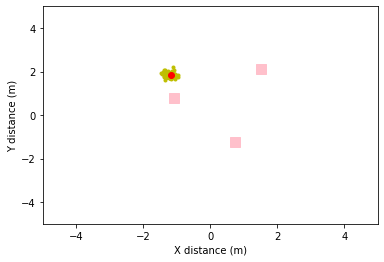

In [22]:
from IPython.display import clear_output
from time import sleep

## Plotting code
def graph(particleSet, roboPose):
    fig = plt.figure(1)

    for j in range(0, 3):
        plt.plot(tags_arr[j, 0], tags_arr[j, 1], 's',
                             markersize=10, color='pink')

    for j in range(0, len(particleSet)):
        plt.plot(particleSet[j,0], particleSet[j, 1], 'o', markersize= 3, color='y')

    plt.plot(roboPose[0], roboPose[1], 'o', markersize=6, color='r')

    plt.xlabel('X distance (m)')
    plt.ylabel('Y distance (m)')
    plt.axis([-5, 5, -5, 5])
    plt.show()

##animating - plotting all the saved particlesets
for i in range(len(psets)):
    particleSet = psets[i]
    graph(particleSet, robot[i])
    sleep(0.00001)
    clear_output(wait=True)

Now run the `%timeit` cells below to see how much Numba optimized the particle filter. The `p_filter` and the `p_filter_jit` functions both take in the number of particles as an argument. Try changing this value to different numbers to see how as the number of particles increases, Numba enhancement becomes more impactful.

*You may stop the cell above which is animating the particle filter to be able to run the next cells.*


In [12]:
%timeit p_filter(100) ##runtime of particle filter without Numba

16.4 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit p_filter_jit(100) ##runtime of particle filter with Numba

1.39 s ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
